In [1]:
from dask_image.imread import imread
import dask.array as da
import os
import numpy as np
import joblib
import dask  # Import Dask first
dask.config.set({'dataframe.query-planning': False})  # Disable query-planning

import dask.dataframe as dd  # Now import dask.dataframe
import pandas as pd
import dask.dataframe as dd
from spatialdata import read_zarr

c:\Users\matti\.conda\envs\ilastik_napari_182\Lib\site-packages\dask\dataframe\__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


In [40]:
sdata = read_zarr(r"C:\Users\matti\Documents\HOGENT\Jaar-3\bachproef\Bachelor_proef_VIB\Testdata_MACSima\Testdata_CA.zarr")

sdata

c:\Users\matti\.conda\envs\ilastik_napari_182\Lib\site-packages\zarr\creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


SpatialData object, with associated Zarr store: C:\Users\matti\Documents\HOGENT\Jaar-3\bachproef\Bachelor_proef_VIB\Testdata_MACSima\Testdata_CA.zarr
├── Images
│     ├── 'channel_0': DataArray[cyx] (1, 4500, 7000)
│     ├── 'channel_1': DataArray[cyx] (1, 4500, 7000)
│     ├── 'channel_2': DataArray[cyx] (1, 4500, 7000)
│     ├── 'channel_3': DataArray[cyx] (1, 4500, 7000)
│     ├── 'channel_4': DataArray[cyx] (1, 4500, 7000)
│     ├── 'channel_5': DataArray[cyx] (1, 4500, 7000)
│     ├── 'channel_6': DataArray[cyx] (1, 4500, 7000)
│     ├── 'channel_7': DataArray[cyx] (1, 4500, 7000)
│     ├── 'channel_8': DataArray[cyx] (1, 4500, 7000)
│     ├── 'channel_9': DataArray[cyx] (1, 4500, 7000)
│     ├── 'channel_10': DataArray[cyx] (1, 4500, 7000)
│     ├── 'channel_11': DataArray[cyx] (1, 4500, 7000)
│     ├── 'channel_12': DataArray[cyx] (1, 4500, 7000)
│     ├── 'channel_13': DataArray[cyx] (1, 4500, 7000)
│     ├── 'channel_14': DataArray[cyx] (1, 4500, 7000)
│     ├── 'channel_15': 

In [100]:
sdata.shape

AttributeError: 'SpatialData' object has no attribute 'shape'

In [88]:
len(list)

153

In [ ]:
from PIL import Image as im
IMAGE_SIZE = 512
def image_splitter(array:np.ndarray, image_slice_size=IMAGE_SIZE):
    shape = array.shape
    images = []
    for i in range(shape[0]//image_slice_size):
        for j in range(shape[1]//image_slice_size):
            images.append(array[i*image_slice_size:i*image_slice_size+image_slice_size, j*image_slice_size:j*image_slice_size+image_slice_size])

    return np.array(images)

images = image_splitter(sdata['labels'].data.squeeze())

images.shape

(104, 512, 512)

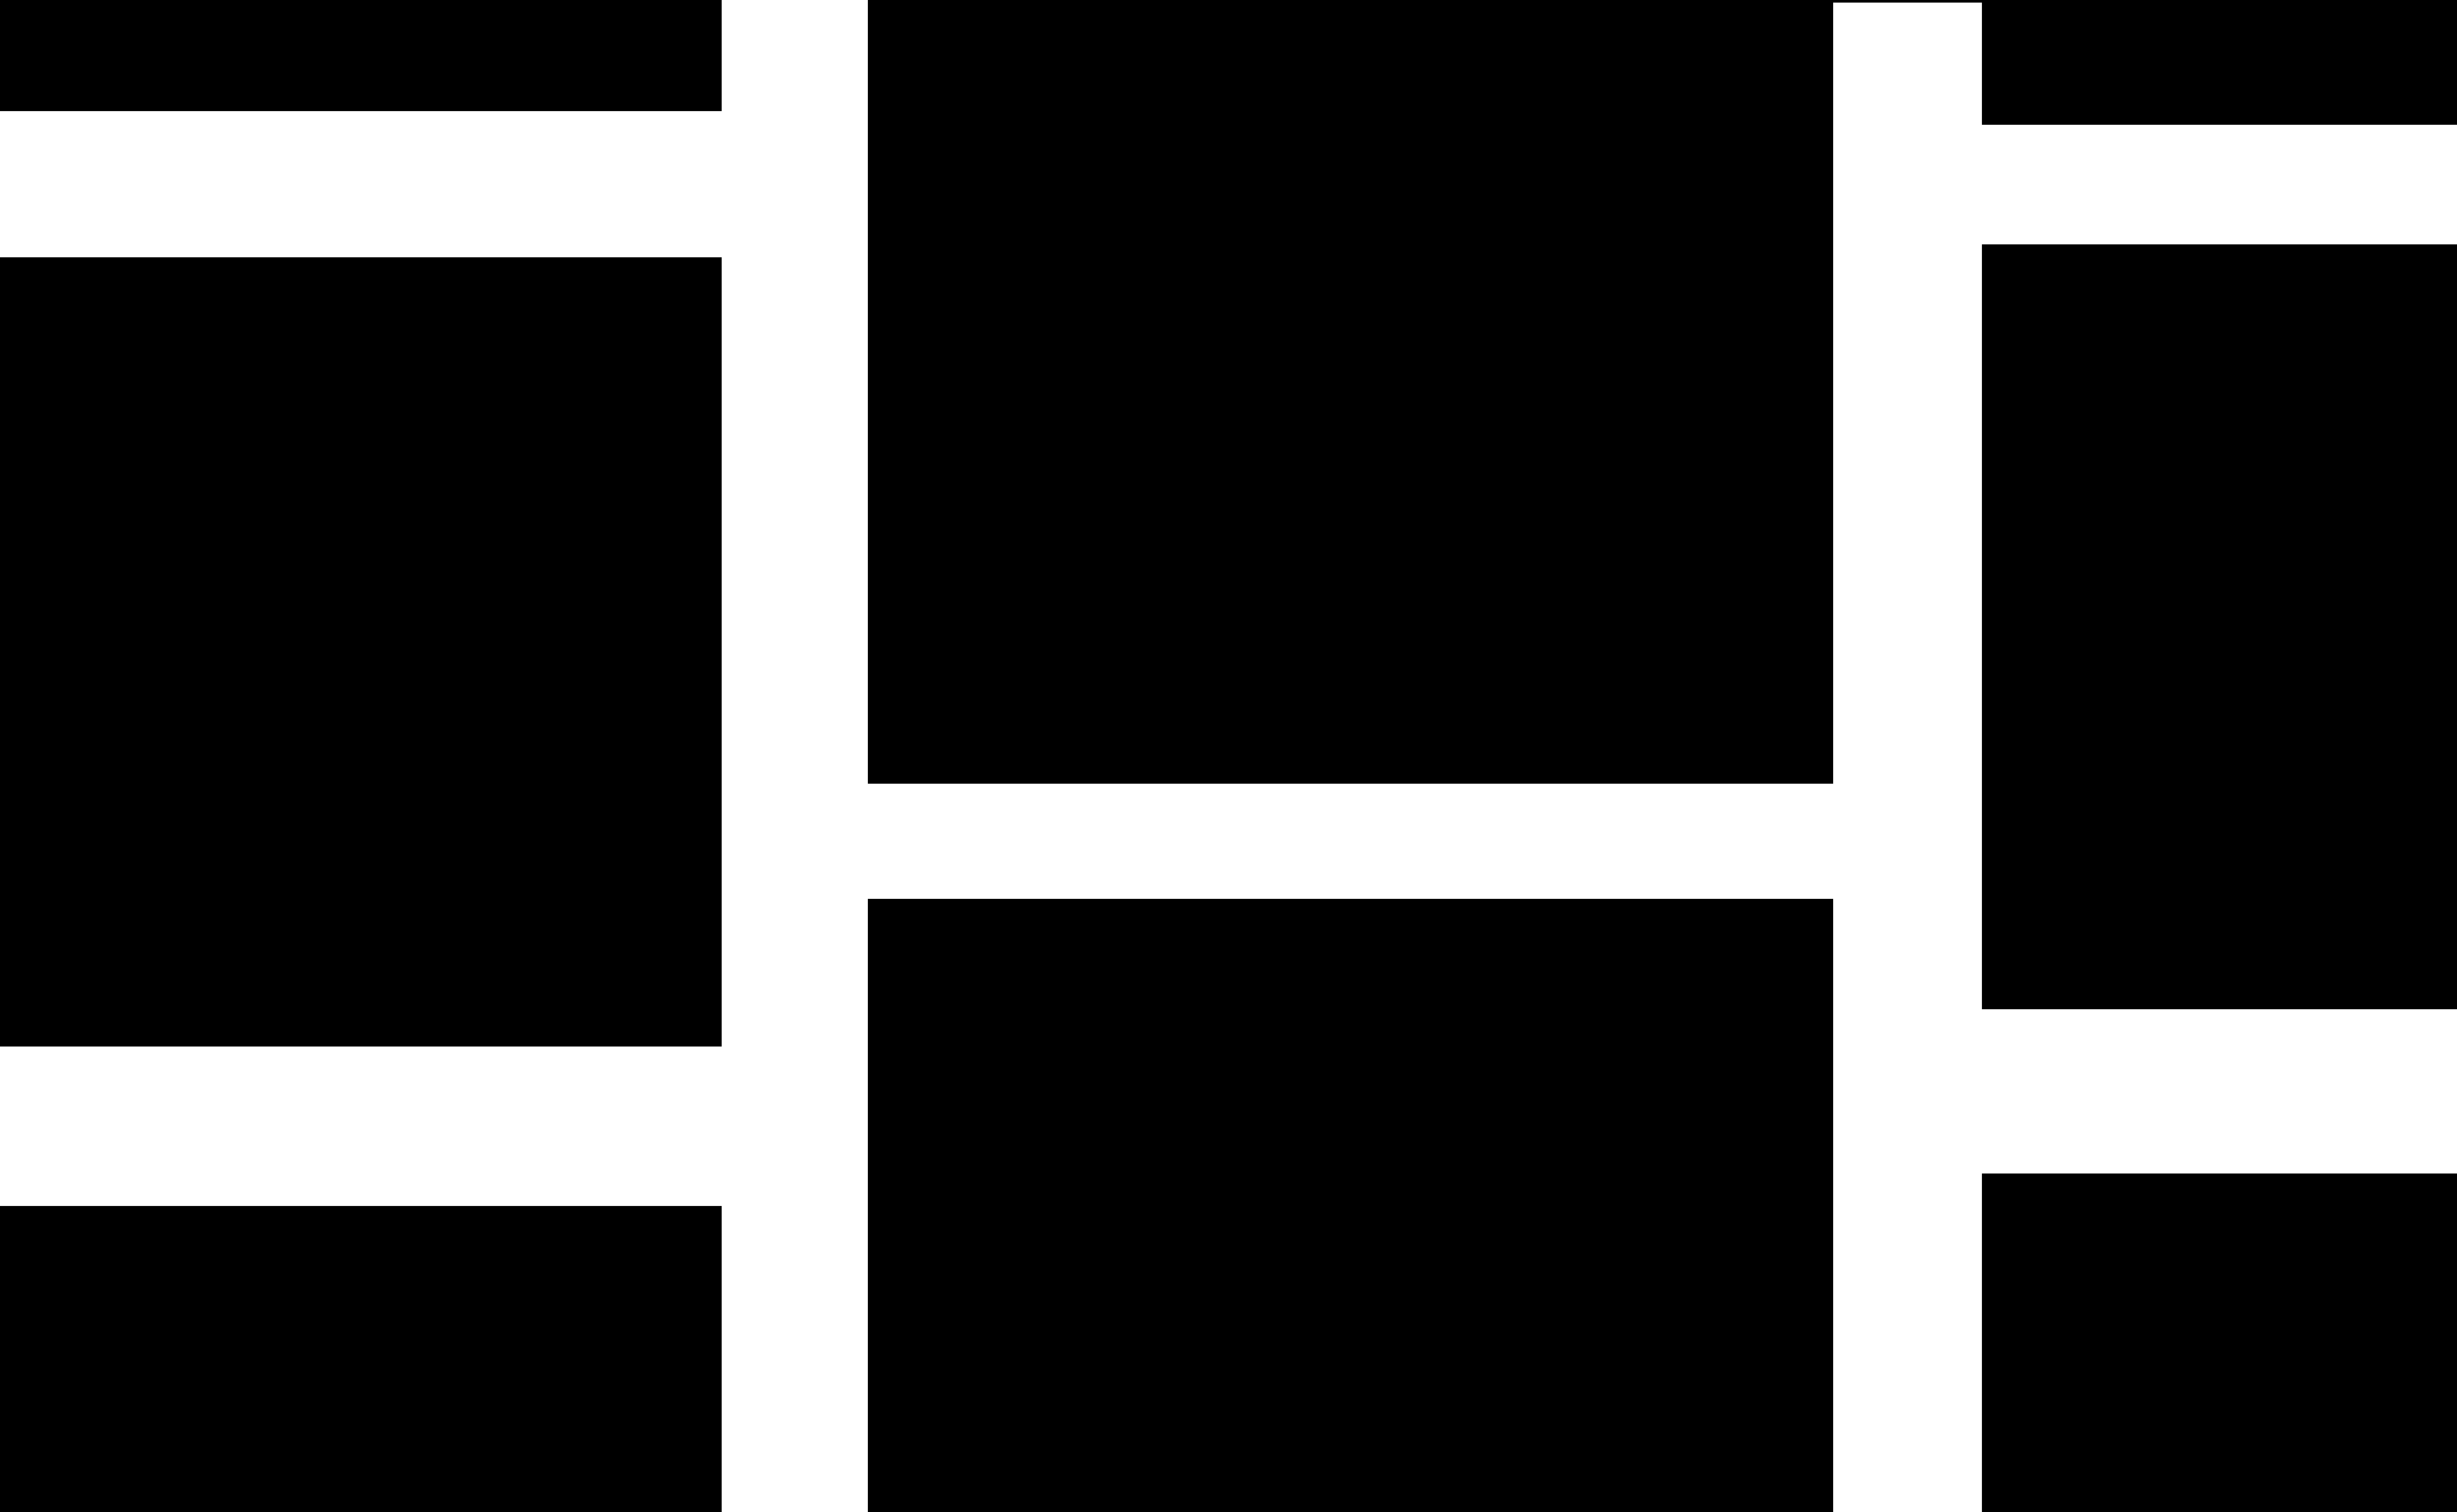

In [78]:
def image_stitcher(data:np.ndarray, shape, image_slice_size):
    x = shape[0]//image_slice_size
    y = shape[1]//image_slice_size

    vert = []

    for i in range(x):
        vert.append(np.concatenate(data[i*y:i*y+y], axis=1))

    return np.concatenate(vert, axis=0)
    
        
im.fromarray(image_stitcher(images, (4500, 7000), IMAGE_SIZE))

In [9]:
def extract_patches_per_channel(sdata, channel, patch_size=512, stride=256):
    """Extract patches from a specific channel in SpatialData."""
    img = sdata.images[f"channel_{channel}"].values[0] / 225
    labels = sdata.labels["labels"].values // 255

    patches, label_patches = [], []
    h, w = img.shape

    for i in range(0, h - patch_size, stride):
        for j in range(0, w - patch_size, stride):
            img_patch = img[i:i+patch_size, j:j+patch_size]
            label_patch = labels[i:i+patch_size, j:j+patch_size]

            if img_patch.shape == (patch_size, patch_size):
                patches.append(img_patch)
                label_patches.append(label_patch)

    return np.array(patches), np.array(label_patches)

X, Y = extract_patches_per_channel(sdata, channel=0, patch_size=512, stride=256)

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Input, Dropout
from tensorflow.keras.models import Model


In [7]:
def unet_model_smaller(input_size=(512, 512, 1)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    # Decoder
    u4 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)  # Match c2 filters
    u4 = concatenate([u4, c2])
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(u4)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)  # Match c1 filters
    u5 = concatenate([u5, c1])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = Model(inputs, outputs)
    return model


In [8]:
def unet_model(input_size=(512, 512, 1)):
    inputs = Input(input_size)

    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    return model


In [9]:
extract_patches_per_channel

<function __main__.extract_patches_per_channel(sdata, channel, patch_size=512, stride=256)>

In [ ]:
batch_size = 8
epochs = 5

channels = 1

for channel in range(channels):
    print(f"\nTraining U-Net for Channel {channel}...\n")

    X, Y = extract_patches_per_channel(sdata, channel, patch_size=1024, stride=512)

    
    X = np.expand_dims(X, axis=-1)  
    Y = np.expand_dims(Y, axis=-1)  

    
    model = unet_model_smaller(input_size=(1024, 1024, 1))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(X, Y, batch_size=batch_size, epochs=epochs, validation_split=0.2)

    model.save(f"unet_channel_{channel}.h5")

    print(f"\nFinished training U-Net for Channel {channel}!\n")


Training U-Net for Channel 0...

Epoch 1/5


In [ ]:
new_model = tf.keras.models.load_model("unet_channel_0.h5")

X, Y =  extract_patches_per_channel(sdata, 2, patch_size=512, stride=256)

new_model.predict(X)

 3/13 ━━━━━━━━━━━━━━━━━━━━ 2:40 16s/step